In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dataset import get_manchester

In [74]:
def morisita(a, b, randomize=False):
    if randomize:
        b.index = np.random.permutation(b.index)
    a, b = a.align(b, fill_value=0)
    numer = np.dot(a, b)
    denom = np.square(a).sum() + np.square(b).sum()
    return 2 * numer / denom

In [75]:
def morisita_child_adult(df):
    child = df[df.speaker.eq('CHI')].ngram.value_counts()
    adult = df[df.speaker.eq('MOT')].ngram.value_counts()
    return morisita(child, adult)

In [76]:
def per_session_plot(title):
    plt.grid()
    plt.xticks(np.arange(1,35))
    plt.title(title)
    plt.legend()
    plt.show()

# Quick Test 

Testing example from "Testing for Significance of Morisita's, Horn's and Related Measures of Overlap"

The morisita calculation for X and Y should be 0.83

In [77]:
x = pd.Series([.2, .3, .5])
y = pd.Series([.1, .6, .3])
morisita(x, y)

0.83333333333333326

In [ ]:
source = get_manchester("/home/paul/corpora/Manchester/**/*", cached=Truetr, gram_sizes=[1])
unigrams = source[0]

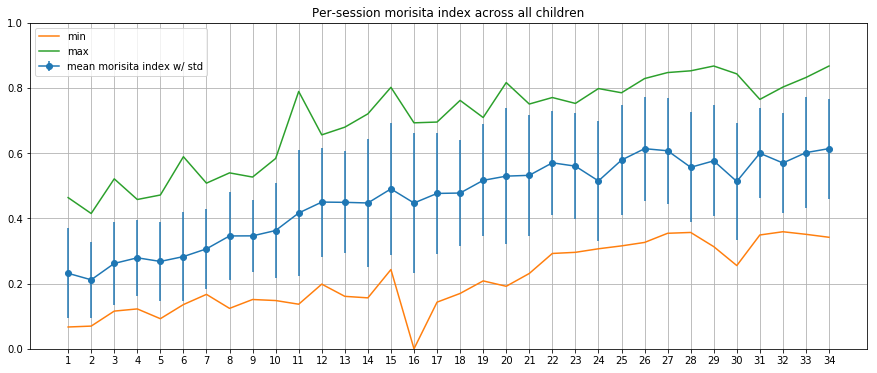

In [78]:
plt.rcParams['figure.figsize'] = 15, 6

groups = unigrams.groupby(['corpus', 'session']).apply(morisita_child_adult)
stats = groups.groupby(level='session').describe()
plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean morisita index w/ std', marker='o');
plt.plot(stats.index, stats['min'])
plt.plot(stats.index, stats['max'])
plt.ylim(0, 1)
per_session_plot('Per-session morisita index across all children')

In [79]:
def plot_child(name, width=2, style='-', title=None, plot=True):
    m = unigrams[unigrams.corpus.eq(name)].groupby(['session']).apply(morisita_child_adult)
    m = m.align(pd.Series(index=np.arange(1, 35)))[0]
#    plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean morisita index w/ std', marker='o');
    plt.plot(stats.index, m, style, label=name, linewidth=width)
    plt.ylim(0, 1)
    if plot:
        per_session_plot(title or name)

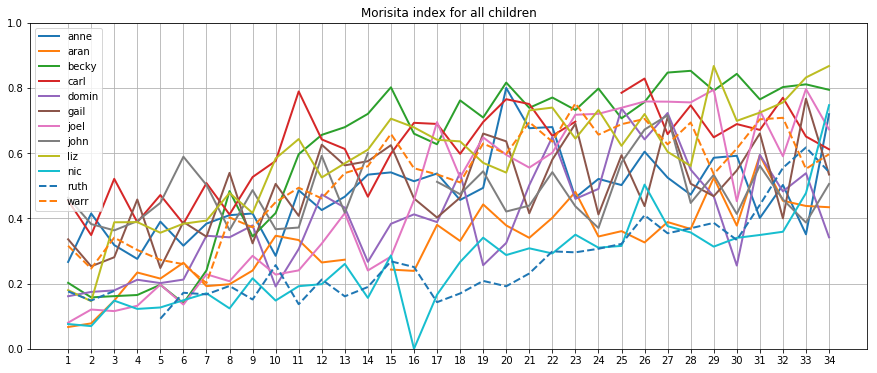

In [80]:
plt.rcParams['figure.figsize'] = 15, 6

children = unigrams.corpus.unique()

from itertools import cycle, chain, repeat

styles = cycle(chain(*(repeat(x, 10)
                 for x in '- -- -. :'.split(' '))))

for index, child in enumerate(children):
    plot_child(child, 2, next(styles), plot=False)
plt.legend();
per_session_plot('Morisita index for all children')

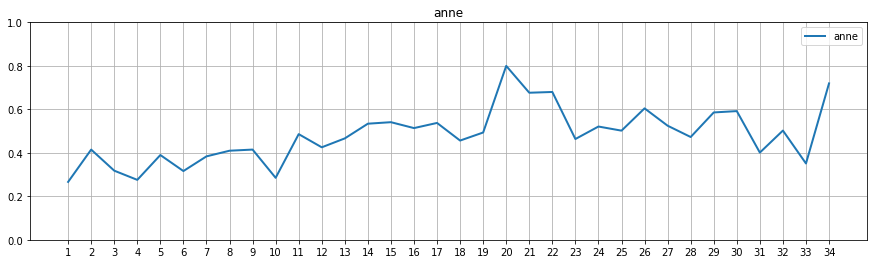

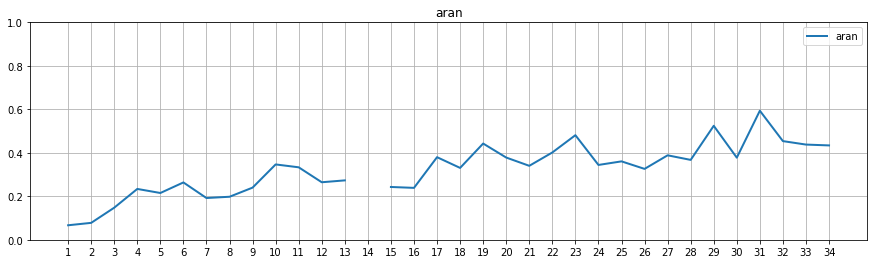

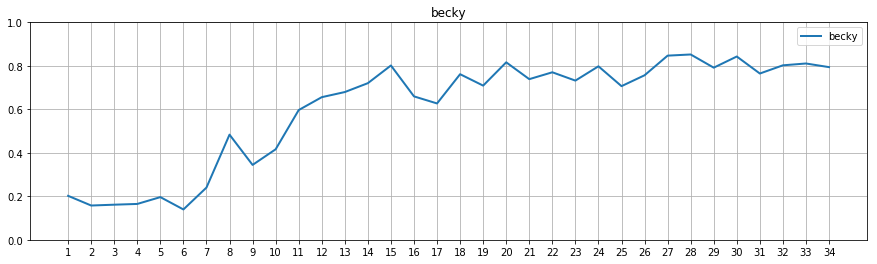

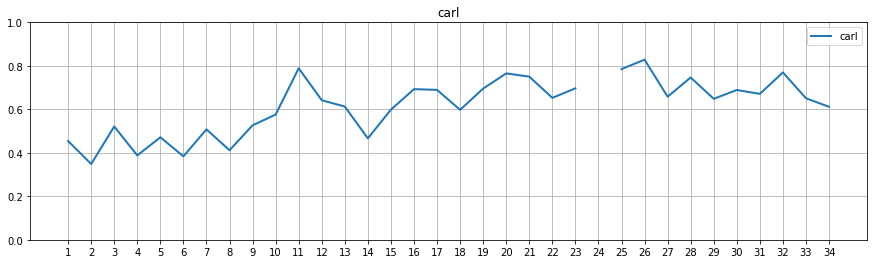

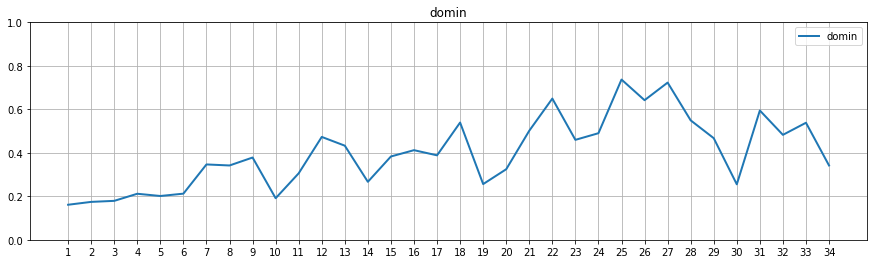

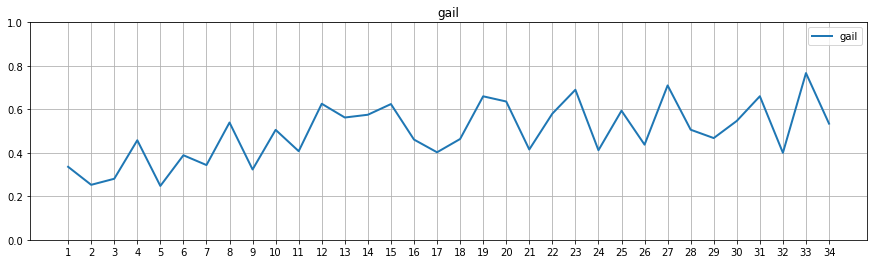

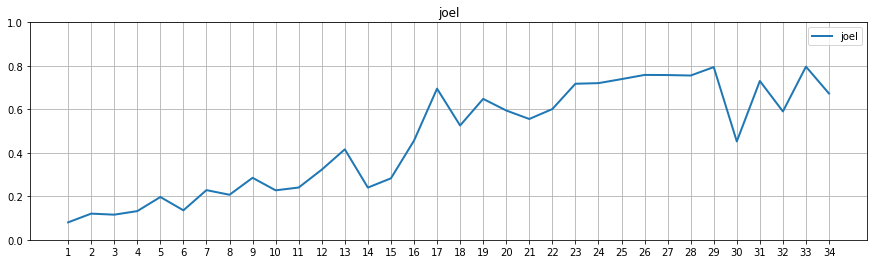

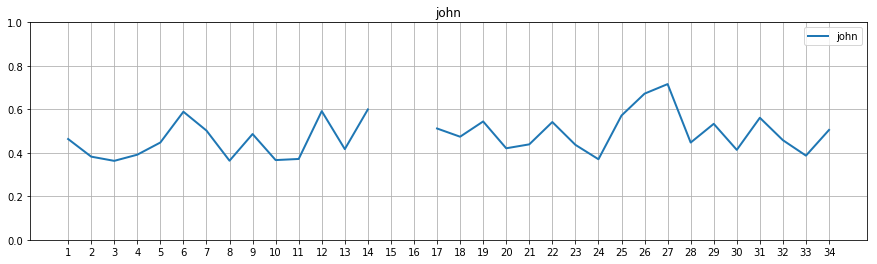

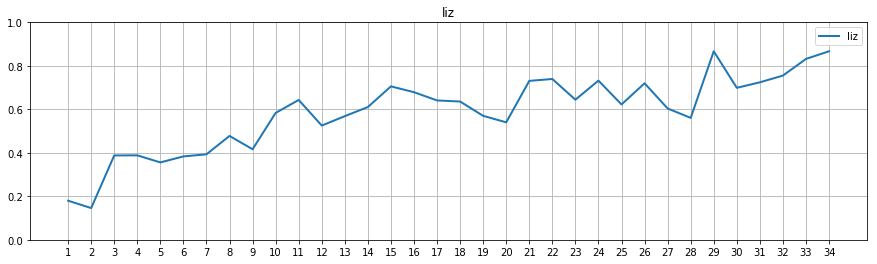

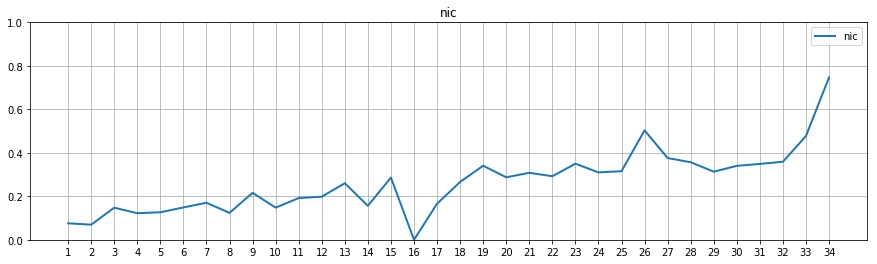

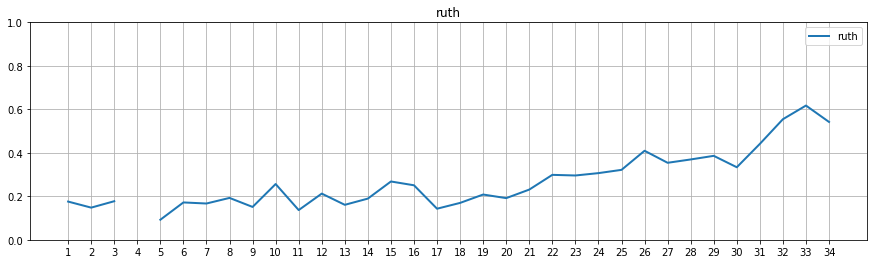

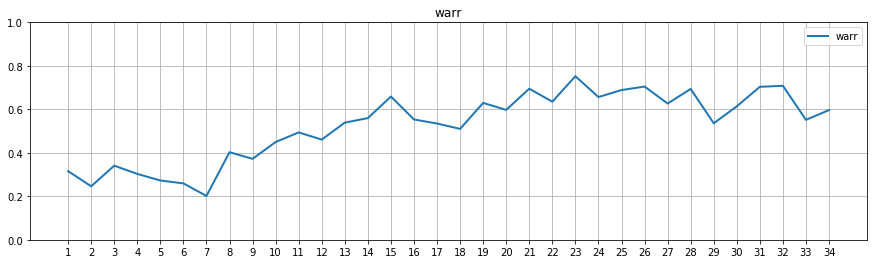

/home/paul/.virtualenvs/formulae/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


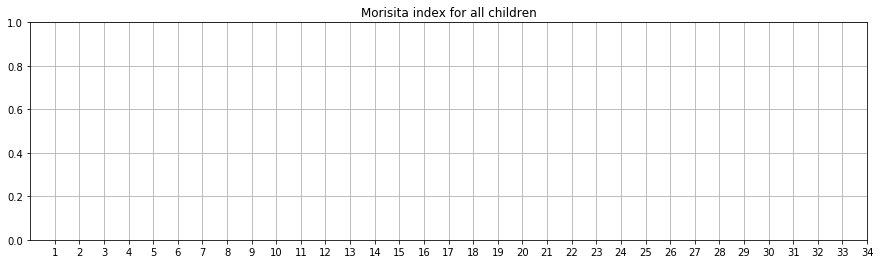

In [82]:
plt.rcParams['figure.figsize'] = 15, 4

children = unigrams.corpus.unique()

for index, child in enumerate(children):
    plot_child(child, 2)
plt.legend();
per_session_plot('Morisita index for all children')